# Statistical Arbitrage Pairs Trading Strategy
- This strategy is based upon exploiting **forecasted inefficiencies** in pricing
- To achieve this, we must find a pair of stocks with **cointegrated log-returns**
- Once we find a pair that meets this criteria, it is statistically feasible to find a **linear combination** of the two stocks that is **stationary** i.e we can find a **stationary spread**
- A stationary time series is one in which each data point is drawn from the **same distribution**
- This means stationary time series exhibit **mean reverting** tendencies that provide trading opportunites

#### Packages

In [2]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import  coint, adfuller
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

#### Check for Stationarity
- Below I provide a function that implents an **Augmented Dickey-Fuller** test for stationarity of a time series

In [3]:
def check_for_stationarity(X, cutoff = 0.01):
    # Augmented Dickey-Fuller has H_0 that TS has a unit root -> non stationary
    # H_1 is that TS is stationary
    # So, low p-value -> stationary

    p_value = adfuller(X)[1]

    if p_value < cutoff:
        print(f'p-value {str(p_value)}. TS {X.name} is likely stationary')
        return
    else:
        print(f'p-value {str(p_value)}. TS {X.name} is likely non-stationary')
        return 

#### Fetching Pricing Data
- Below I provide a function to fetch **daily close** prices from an inputted ticker
- In this notebook we use prices from **Ford** and **General Motors** in the time period 01/01/2022 to 01/01/2023
- The motivation for using these stocks is that they are both **American value stocks** in the **same sector** i.e. they are **similar** in many regards
- Given this similarity, there is a higher chance of a **consistent relationship** between the two stocks

In [4]:
def get_pricing(ticker, start_date, end_date, freq):
    data = yf.download(ticker, start= start_date, end= end_date, interval= freq)
    data.reset_index(inplace=True)
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    X = pd.Series(data['Close'])
    X.name = ticker
    X.index = pd.to_datetime(data['Date'])
    return X

symbols = ['F', 'GM']

# Price Data
X1 = get_pricing(symbols[0], "2022-01-01", "2023-01-01", "1d")
X2 = get_pricing(symbols[1], "2022-01-01", "2023-01-01", "1d")

# Log Returns
lr_X1 = np.log(X1 / X1.shift(1)).dropna()
lr_X2 = np.log(X2 / X2.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Testing for Cointegration
- Below I use the **coint** function to implement an **Engel-Granger two-step cointegration test** between the log-returns of the two stocks
- Low p-value here **implies cointegrated log-returns**

In [6]:
res = coint(lr_X1, lr_X2)
print(f'Test Statistic; {res[0]}')
print(f'p-value; {res[1]}')

Test Statistic; -14.883503163520839
p-value; 1.3741903334547656e-26


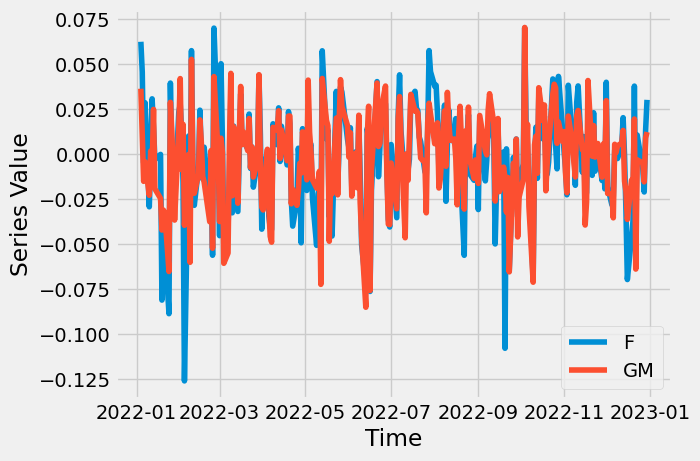

In [7]:
plt.plot(lr_X1.index, lr_X1.values)
plt.plot(lr_X2.index, lr_X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()

#### Linear Regression to Find Spread
- Now I perform a **linear regression** between the two series to find the **appropriate ratio** for the stationary spread

In [8]:
lr_X1 = sm.add_constant(lr_X1)
results = sm.OLS(lr_X2, lr_X1).fit()

# Dropping the constant column
lr_X1 = lr_X1[symbols[0]]
results.params

const   -0.000538
F        0.735272
dtype: float64

#### Finding the Spread Series
- Below I plot the series for the stationary spread
- Further, I **confirm stationarity** of the calculated spread

p-value 2.5064241890301267e-27. TS Z is likely stationary


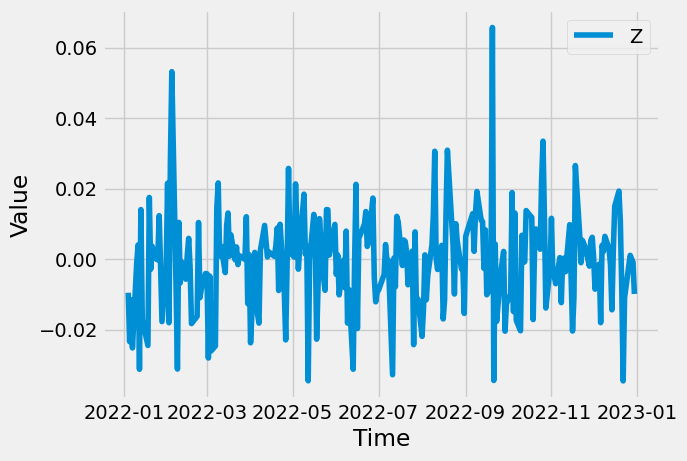

In [10]:
b = results.params[symbols[0]]
Z = lr_X2 - b*lr_X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend([Z.name])

check_for_stationarity(Z)

#### Finding Thresholds
- Now I find **upper** and **lower thresholds** of the returns to act as trading signals on the test data
- Note here we use **two standard deviations** as our threshold

In [11]:
mu = Z.mean()
std =  Z.std()
upper_threshold = mu + 2*std
lower_threshold = mu - 2*std
upper_threshold, lower_threshold

(0.027139679153047276, -0.028216648952096662)

#### Fetching Test Data
- Now I test the strategy on the **netx 6 months** of data for the two stocks
- I return the **cumulative return**, **Sharpe-Ration**, **max drawdown** and **number of trades** below

In [26]:
# Get test data 
test_X1 = get_pricing(symbols[0], "2023-01-02", "2023-06-01", "1d")
test_X2 = get_pricing(symbols[1], "2023-01-02", "2023-06-01", "1d")
test_lr_X1 = np.log(test_X1 / test_X1.shift(1)).dropna()
test_lr_X2 = np.log(test_X2 / test_X2.shift(1)).dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


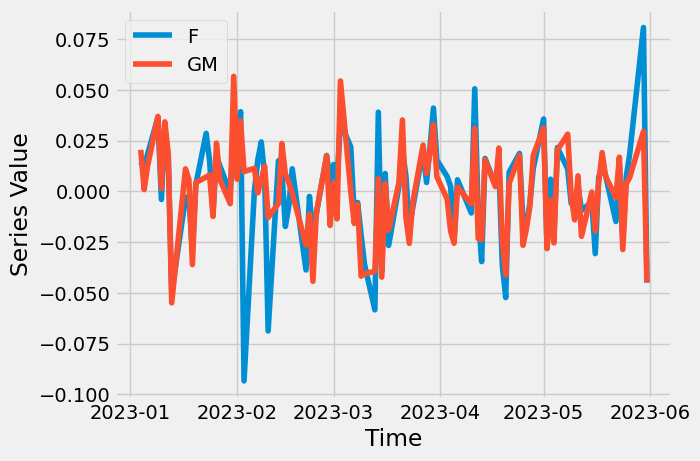

In [27]:
plt.plot(test_lr_X1.index, test_lr_X1.values)
plt.plot(test_lr_X2.index, test_lr_X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([test_lr_X1.name, test_lr_X2.name])
plt.show()

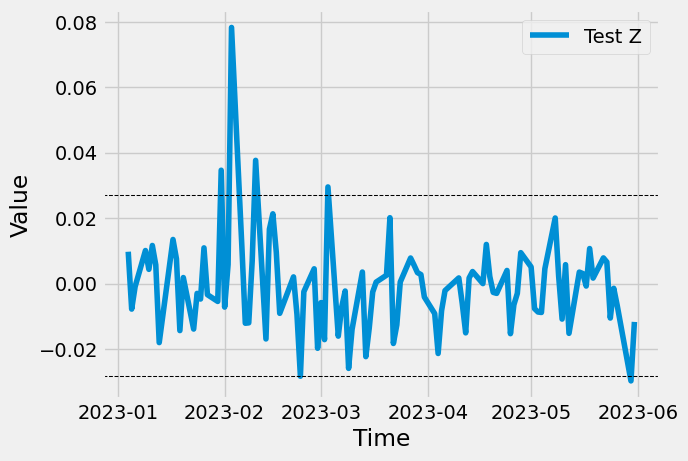

In [28]:
test_Z = test_lr_X2 - b*test_lr_X1
test_Z.name = 'Test Z'

plt.plot(test_Z.index, test_Z.values)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend([test_Z.name])
plt.axhline(upper_threshold, color = 'black', lw = 0.75, ls = '--')
plt.axhline(lower_threshold, color = 'black', lw = 0.75, ls = '--')

In [29]:

# Initialising tracking variables
position = 0 
entry_price = 0  
cumulative_return = 1.0 
daily_returns = [] 

# Simulate over each day in the testing period
for i, spread_return in enumerate(test_Z):
    
    # Entry conditions
    if position == 0:  # No position
        if spread_return > upper_threshold:
            # Short the spread
            position = -1
            entry_price = spread_return
        elif spread_return < lower_threshold:
            # Long the spread
            position = 1
            entry_price = spread_return

    # Exit condition
    elif position != 0:
        # Exit when the spread returns to the mean level
        if (position == 1 and spread_return >= mu) or (position == -1 and spread_return <= mu):
            # Calculate cumulative return for the trade
            trade_return = np.exp((spread_return - entry_price) * position)  # Exponentiate for cumulative return
            cumulative_return *= trade_return  # Update cumulative return
            daily_returns.append(trade_return - 1)  # Track daily profit as simple return
            
            # Reset position
            position = 0
            entry_price = 0
        else:
            # If no exit, daily return is zero (or could be calculated with spread_return if we mark-to-market)
            daily_returns.append(0)

# Finding toal cumulative return
total_cumulative_return = cumulative_return - 1

# Maximum drawdown
cumulative_returns_series = pd.Series((np.array(daily_returns) + 1).cumprod())
drawdown = cumulative_returns_series / cumulative_returns_series.cummax() - 1
max_drawdown = drawdown.min()

# Sharpe ratio
rf = 0.01 / 252
excess_daily_returns = np.array(daily_returns) - rf
sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns) * np.sqrt(252)  # Annualize

# Print results
print("Total Cumulative Return over 6 months:", total_cumulative_return)
print("Total Trades:", len(daily_returns))
print("Maximum Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)

trade_return_df = pd.DataFrame({'Cumulative Return': trade_returns}, index=test_Z.index[:len(trade_returns)])

Total Cumulative Return over 6 months: 0.304088255873328
Total Trades: 8
Maximum Drawdown: 0.0
Sharpe Ratio: 17.284397392774412


#### Further Work
- The spread ratio should be **readjusted** using a rolling window over the test period
- In reality, we should implement this strategy for **many pairs**. This allows us to **diversify** and allow for some pairs to **fall out** of stationarity
- Daily close data is not ideal, we should be using **bid-ask** spread to determine our entry price
- Accounting for **fees** and **price slippage** will eat away at alpha